# Geospatial case study in ML

The 5 steps of data science would include:
    
    1. Acquire the data
    2. Prepare the data and do EDA 
    3. Analyze (Analysis and model deployment)
    4. Report (Estimate metrics)
    5. Act (A/B testing and iteration)
    6. Deploy and monitor

### Packages

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 
tqdm.pandas()
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import sys

# Get a dictionary of all loaded modules
loaded_modules = sys.modules


# Print the name and version of each loaded module
libraries = ['pandas','tqdm','numpy','sys','shapely','seaborn','matplotlib']
for module_name, module in loaded_modules.items():
    if module_name in libraries:
        if hasattr(module, "__version__"):
            print(f"{module_name}=={module.__version__}")

numpy==1.21.4
pandas==1.2.3
matplotlib==3.5.0
tqdm==4.50.2
shapely==1.7.1
seaborn==0.11.1


### Step 1: Acquire the data

#### Origin - Destination data
I was given a set of data which included: Approximately 630000 rows of synthetic ride demand data which resembles the real-life situation in the city of Tallinn:

* start_time - time when the order was made
* start_lat - latitude of the location where the order was made
* start_lng - longitude of the location where the order was made
* end_lat - latitude of the destination point
* end_lng - longitude of the destination point
* ride_value - how much monetary value is in this particular ride


In [44]:
#I will use pandas for the data manipulation
database = pd.read_csv('/home/sako/Data science lessons/bolt/robotex5.csv')

#visualizedatabase.describe().T ten random rows of the imported csv
database.sample(10)

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
81128,2022-03-15 08:53:04.261384999,59.440044,24.737641,59.431363,24.754593,0.336500
198523,2022-03-22 16:00:36.609385000,59.406649,24.733505,59.426206,24.647257,1.314000
165528,2022-03-23 20:12:20.217997000,59.408039,24.689985,59.393868,24.796644,1.531000
355962,2022-03-27 16:35:16.995176000,59.448557,24.736075,59.426747,24.782278,0.881500
413520,2022-03-24 11:30:37.798024000,59.432594,24.729321,59.436364,24.756087,0.385750
268752,2022-03-17 22:06:06.675000000,59.446531,24.873835,59.428972,24.792698,1.234349
560588,2022-03-23 22:10:01.583070000,59.440361,24.750592,59.307806,24.645270,3.958000
35000,2022-03-09 23:02:32.725266000,59.383943,24.672430,59.430086,24.719735,1.438750
192662,2022-03-26 21:01:22.782566000,59.513519,24.829511,59.407760,24.732466,3.228750
600184,2022-03-20 20:14:53.998000000,59.399051,24.670892,59.425477,24.793341,1.849105


### Step 2: Prepare

#### Explore

First we will start doing a few explorations to the data

In [45]:
database.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,627210.000000,627210.000000,627210.000000,627210.000000,627210.000000
mean,59.428682,24.743468,59.397797,24.724847,2.261384
std,0.021764,0.056872,1.392755,1.650709,44.889892
min,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,59.418803,24.713140,59.415215,24.707919,0.545250
50%,59.432069,24.744674,59.430697,24.744335,1.059000
75%,59.439024,24.768115,59.439262,24.773924,1.712000
max,59.566998,24.973743,61.552744,144.966110,3172.701000


We can see that the data is complete and we do not have any missing values.

array([[<AxesSubplot:title={'center':'start_lat'}>,
        <AxesSubplot:title={'center':'start_lng'}>],
       [<AxesSubplot:title={'center':'end_lat'}>,
        <AxesSubplot:title={'center':'end_lng'}>],
       [<AxesSubplot:title={'center':'ride_value'}>, <AxesSubplot:>]],
      dtype=object)

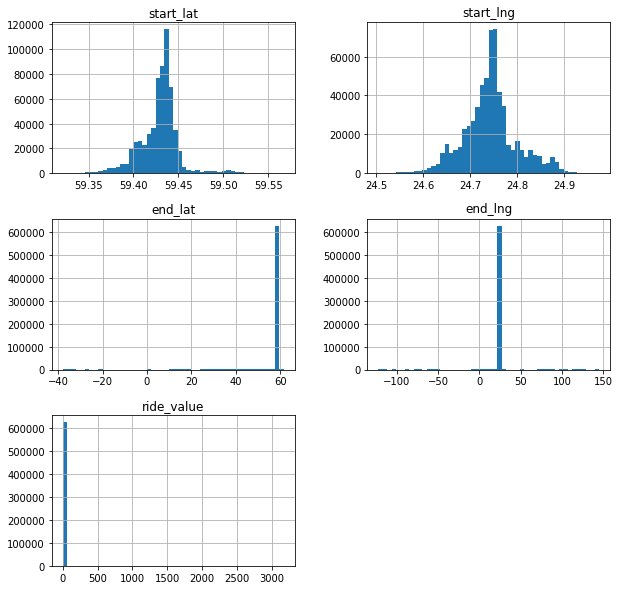

In [46]:
database.hist(figsize=(10,10),bins=50)

We can see that the data is quite centralized and the ride values are quite small. 

Let's also check for correlations. 

#### Clean, select, transform

At this phase the data is not usable yet hence will check what it includes, and we will work to explore and pre-prep it to be able to use it for deploying in the model. 

We will start by exploring trip information. We will convert the map projections of all the data from WGS84 to Estonian Coordinate System of 1997 since it has higher accuracy. 

In [47]:
#For the region of Tallinn
USER_EPSG = 3301

In [48]:
#create geodataframe for pick ups
print('converting pick ups')
start = [ Point(xy) for xy in zip(database.start_lng,database.start_lat) ]
gdf_start = gpd.GeoDataFrame(geometry = start,crs='epsg:4326').to_crs(USER_EPSG)
database['X_pick'] = gdf_start.geometry.x
database['Y_pick'] = gdf_start.geometry.y

print('converting drop offs')
end = [ Point(xy) for xy in zip(database.end_lng,database.end_lat) ]
gdf_end = gpd.GeoDataFrame(geometry = end,crs='epsg:4326').to_crs(USER_EPSG)
database['X_drop'] = gdf_end.geometry.x
database['Y_drop'] = gdf_end.geometry.y


converting pick ups
converting drop offs


Let's now convert the time into a more machine learning readable values (unix timestamps) and generate a new dataframe for usage.

In [49]:
database['timestamp'] = pd.to_datetime(database.start_time).astype(int)/10**9
df = database[['timestamp','X_pick','Y_pick','X_drop','Y_drop','ride_value']]

In [50]:
df.describe()

,timestamp,X_pick,Y_pick,X_drop,Y_drop,ride_value
count,6.272100e+05,627210.000000,6.272100e+05,6.272100e+05,6.272100e+05,627210.000000
mean,1.647371e+09,542197.584707,6.588105e+06,5.393640e+05,6.586525e+06,2.261384
std,6.946702e+05,3213.321104,2.443914e+03,2.283149e+05,1.181326e+05,44.889892
min,1.646093e+09,528697.463224,6.576120e+06,-1.826490e+07,-7.036577e+06,0.107628
25%,1.646784e+09,540479.993231,6.586993e+06,5.401858e+05,6.586593e+06,0.545250
50%,1.647419e+09,542266.653598,6.588487e+06,5.422466e+05,6.588329e+06,1.059000
75%,1.647985e+09,543590.092218,6.589267e+06,5.439280e+05,6.589291e+06,1.712000
max,1.648512e+09,555203.729668,6.603546e+06,2.097293e+07,1.524474e+07,3172.701000


Let's check the clean dataframe and the correlations

It's clear that this is a synthetic data and the the pick up and drop coordinates were generated from a single array and randomly meshed on the map. 

In [51]:
database['distances'] = gdf_start.geometry.distance(gdf_end)

<AxesSubplot:xlabel='distances', ylabel='ride_value'>

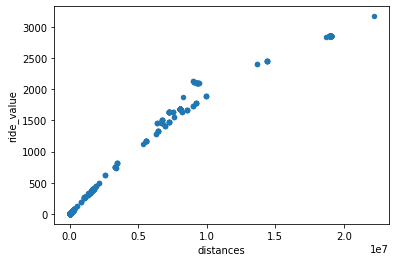

In [52]:
database.plot(x='distances',y='ride_value',kind='scatter')

From the GADM website (https://gadm.org/data.html), I downloaded the map of Estonia and filtered out city of Tallinn. Let's visualize the results.

In [53]:
#import maps
gdf_estonia = gpd.read_file('/home/sako/Data science lessons/bolt/estonia_map/gadm40_EST_3.shp')
gdf_tallinn = gdf_estonia.explode().query('NAME_2 == "Tallinn"')
gdf_tallinn['zone_NO'] = list(range(len(gdf_tallinn)))

<AxesSubplot:xlabel='X_pick', ylabel='Y_pick'>

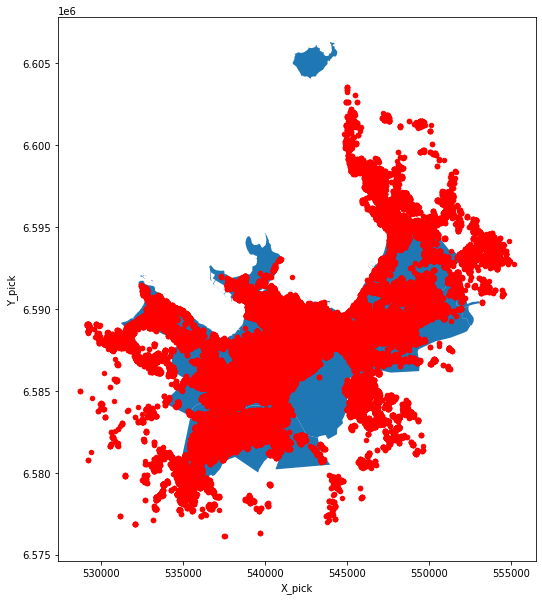

In [54]:
ax = gdf_tallinn.to_crs(USER_EPSG).plot()
df.plot(ax=ax,color='red',kind='scatter',x='X_pick',y='Y_pick',figsize=(10,10))

### Step 3: Deploying a model

For the purpose of this assignment and in a simplified way, we will simply try to estimate the **ride_value** using Linear regression. We will use time and location as features and the **ride_value** as the label. 

After the preparing the data one last transformation can be beneficial which is normalization. I will standardize the data to use it for deployment 

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#Standardize
y = np.array(df.ride_value)
X = np.array(df[['timestamp','X_pick','Y_pick','X_drop','Y_drop']])
X = StandardScaler().fit_transform(X)

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

#apply model
model = LinearRegression().fit(X_train,y_train)

#re-predict the test database
y_pred = model.predict(X_test)




### Step 4: Report 

Let's plot the results and see the predicted values

In [56]:
from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'[INFO]: R^2 = {r2:.2f}')
print(f'[INFO]: RMSE = {rmse:.2f}')


[INFO]: R^2 = 0.56
[INFO]: RMSE = 29.54


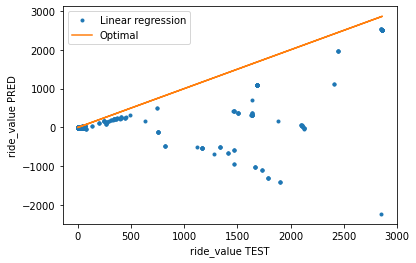

In [57]:
plt.plot(y_test,y_pred,'.',label='Linear regression')
plt.plot(y_test,y_test,label='Optimal')
plt.legend()
plt.xlabel("ride_value TEST")
plt.ylabel("ride_value PRED")

plt.show()

The result is quite interesting because we can see that all the predicted which are small are quite close to the optimal result and as the ride value increase the heteroskedasticity increase in a semi beneath a threshold scale. In most the cases the prediction is underestimated. 

In this work it is quite clear that using only ride_value which is directly correlated to the distance will give a linear correlation and help us estimate the ride value. 

When we start predict based on the latitude longitude and time things started to diverge and linear regression was unable to estimate correctly the high ride values. 


## Step 5: Act

### Post analysis and iteration

Usually for a data science project, after we make conclusions it is time to reiterate and check why our results were not that accurate, so we can:

Try different techniques:
* Prepare the historic data
* Try different regression algorithms and ensemble models

For example: *Demand Prediction of Ride-Hailing Pick-Up Location Using Ensemble
Learning Methods* by Carson-Bell et al. 2021


Try different paradigms:
* Implement time series prediction algorithms (LSTM, ARIMA, Prophet,etc ... )
* Apply time series backtesting ( window based cross-validation)
* ABM models
* Zonal predictions system instead of point predictions.  


### A/B testing

Let's say we want to see if promotions is increasing the number of orders made for each user for food delivery and encouraging people to order more than usual. 

Hypothesis: 
* *Case A*: Personalization based promotions based on history of rides and ride values for location frequented a lot like work or university. 
* *Case B*: Random promotions

Target audience: 
* People who at least have one order per month ... (Frequent users) 

Algorithmically:
* Will this mock AI/recommender have an effect on the customers? 

Check results: 
* Yes: The total number of orders increased especially for the favorite places; we see that is the number of orders per month increased so people are more encouraged to order. 
* No: The number of orders stayed the same. 


**What we will learn**: 
Based on the results and the customer information, we will learn new things and aim to change the method of implementation of promotions based on the behavior of customers. And using recommender systems will increase number of orders and as a result the revenues.   


### Additional Data
Use new additional data:
* Weather changes
* Special events
* Time of day and weekday
* Rush hours information  and street traffic volumes.  
* Point of intersect (POIs)
* POI ratings to understand the quality of the region 
* Gentrification levels  
* Purchasing power of the community. 
* If the region is a student/university campus you might expect most of student to use public transport and carpool and they won't use the "comfort" version of the service. At least I was like that during my university years. I always waited for discounts and sometimes stopped using taxi hailing since it was out of my budget :) ....  

In [58]:
database.sample(5000).to_csv("data_sample.csv")